# Исследование надежности заемщиков

***Описание проекта:*** 

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении `модели кредитного скоринга` — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

***Описание данных:***

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

***План работы над проектом:***

1. Знакомство с данными;
2. Предобработка данных;
3. Категоризация данных;
4. Исследование данных; 
5. Общий вывод.

## Знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 20)})

In [2]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        df.hist(figsize=(15, 20));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB

            children  days_employed     dob_years  education_id  \
count  21525.000000   19351.000000  21525.000000  21525.000000   
mean       0.538908   63046.497661   

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
15699,0,-2704.845307,42,среднее,1,женат / замужем,0,M,сотрудник,0,208526.384497,строительство жилой недвижимости
14742,0,NaN,23,среднее,1,Не женат / не замужем,4,F,сотрудник,0,NaN,строительство недвижимости
3062,0,NaN,42,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,операции с жильем
15630,0,-1285.169207,37,среднее,1,женат / замужем,0,F,сотрудник,0,76855.314432,образование
2910,0,NaN,28,высшее,0,гражданский брак,1,F,компаньон,0,NaN,сыграть свадьбу


Количество пропусков в таблице: 4348 

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64 

Количество дубликатов в таблице: 54


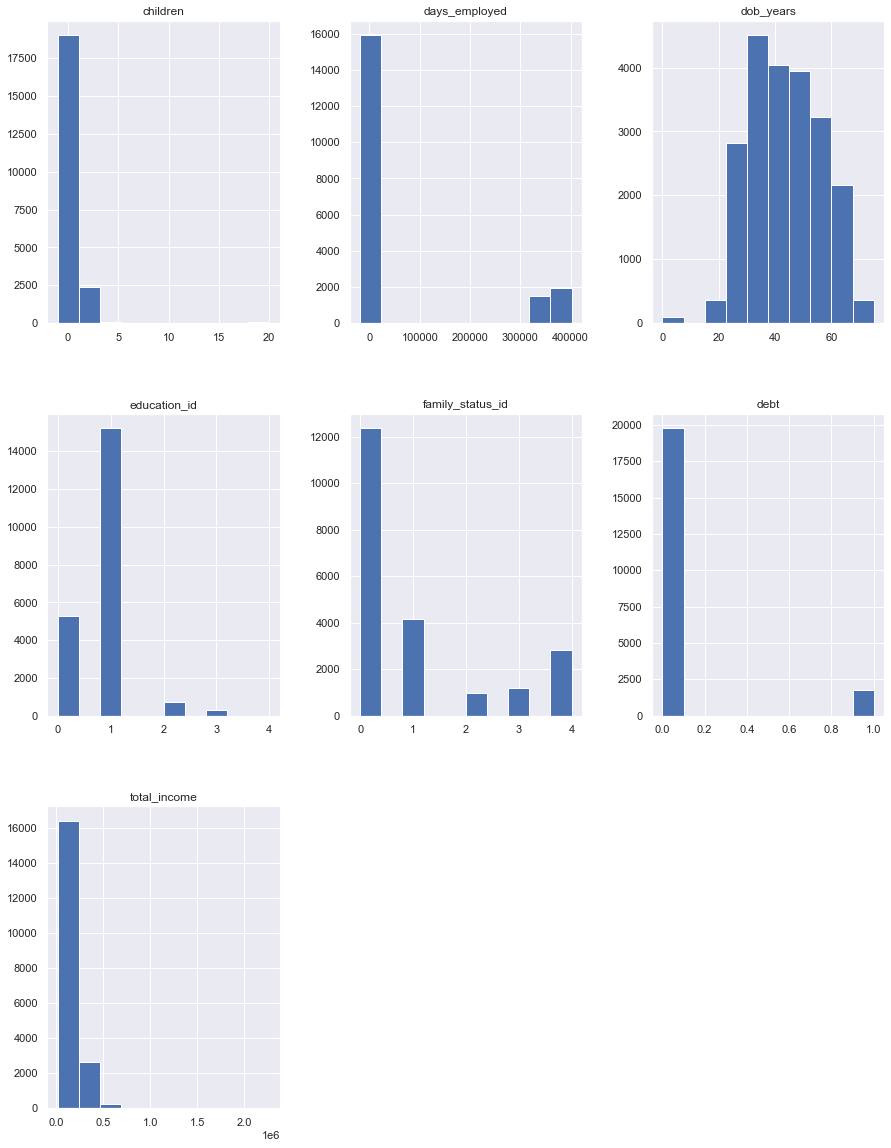

In [3]:
data = pd.read_csv('data.csv')
start(data)

***Вывод:*** При первом знакомстве с данными мы увидели что:
- в таблице `21525` запись и `12` столбцов;
- суммарно в таблице `4348` пропуск, в частности это столбцы `days_employed` и `total_income`;
- так же присутсвуют `54` дубликата;
- по графикам видно, что в столбце `days_employed` есть выбросы; 
- это же и касается столбца `total_income`.

Так же мы видим, что в датасете больше всего семейных пар и болшинство людей из таблицы не имело задолженнностей по возврату кредита. Так же в большинство входят клиенты со средним образованием. Далее в исследовании рассмотрим каждый столбец внимательнее.

## Предобработка данных

Для начала избавимся от пропусков. Столбец `total_income` — хранит данные о доходах. Имеет `2174` пропуска. На сумму дохода сильнее всего влияет тип занятости, поэтому заполним пропуски в этом столбце медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [4]:
employed_median = data.groupby('income_type')['total_income'].agg('median')
for t in employed_median.index:
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = employed_median[t]
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14463,0,-2380.815884,57,среднее,1,женат / замужем,0,M,сотрудник,0,193672.842171,получение высшего образования
7190,-1,-5928.202068,34,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,184315.121979,приобретение автомобиля
13587,2,-1280.574795,42,среднее,1,вдовец / вдова,2,M,сотрудник,0,163081.638750,покупка жилья для семьи
20323,0,-5619.308087,60,среднее,1,женат / замужем,0,F,сотрудник,0,85336.634322,покупка жилья для семьи
14597,2,-1388.764492,36,высшее,0,женат / замужем,0,F,сотрудник,0,89307.797746,покупка коммерческой недвижимости


Далее столбец `days_employed` - общий трудовой стаж в днях. Есть Пропуски (`2174`) и аномальные значение. В частности отрицательные показатели. Для начала приведём их к положительному виду.

In [5]:
data['days_employed'] = abs(data['days_employed'])
data.sample(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
17342,0,NaN,67,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,строительство недвижимости
2467,0,391040.251932,60,Среднее,1,женат / замужем,0,F,пенсионер,0,57702.499264,недвижимость
18162,0,697.283273,36,Среднее,1,Не женат / не замужем,4,M,сотрудник,0,109447.960014,получение дополнительного образования


Далее выведем для  каждого типа занятости медианное значение трудового стажа в днях.

In [6]:
employed_median = data.groupby('income_type')['days_employed'].agg('median')
employed_median

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (`безработные и пенсионеры`) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставьте их как есть. Тем более этот столбец не понадобится нам для исследования. Так как основная задача "*разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.*"

Заполним пропуски в столбце медианными значениями по каждому типу занятости `income_type` как в предыдущем "проблемном" столбце.

In [7]:
data.loc[data['days_employed'].isna(), 'days_employed'] = data.groupby('income_type')['days_employed'].transform('median')
data.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
1837,1,1127.232661,30,среднее,1,женат / замужем,0,F,сотрудник,0,84324.922903,получение образования
17741,0,6941.314248,48,высшее,0,в разводе,3,F,госслужащий,0,202468.148563,покупка жилья для сдачи
9138,0,685.565581,35,среднее,1,Не женат / не замужем,4,F,компаньон,0,126299.644556,строительство жилой недвижимости
3118,1,355.825666,42,среднее,1,гражданский брак,1,F,сотрудник,0,175336.988110,сделка с автомобилем
17139,0,395903.924621,55,высшее,0,женат / замужем,0,M,пенсионер,0,242890.011517,строительство жилой недвижимости
17055,1,945.067110,29,среднее,1,женат / замужем,0,F,сотрудник,0,96489.338884,операции с жильем
2296,0,1369.869469,48,среднее,1,женат / замужем,0,M,компаньон,0,274506.969942,на покупку автомобиля
9749,1,1219.774709,40,среднее,1,гражданский брак,1,F,сотрудник,0,63900.354032,сделка с автомобилем
11983,1,1249.862248,39,СРЕДНЕЕ,1,женат / замужем,0,F,сотрудник,0,54971.155008,дополнительное образование
1888,1,1409.001754,30,среднее,1,гражданский брак,1,F,сотрудник,0,138501.271006,профильное образование


Отлично! Посмотрим столбец `children`.

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце есть два аномальных значения (отрицательное и очень большое). Удалим строки, в которых встречаются такие значения из датафрейма.

In [9]:
data = data.loc[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Убедимся, что заполнили все пропуски.

In [10]:
print(data.isna().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


Хорошо. Так же мы заметили, что не все типы данных правильно обозначены в таблице. Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [11]:
data['total_income'] = data['total_income'].astype('int')
data['total_income'].dtype

dtype('int32')

Отлично! Далее столбец `education`.

In [12]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Обработаем неявные дубликаты. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведум их к нижнему регистру.

In [13]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15136
высшее                  5237
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

Далее проверим, сколько на текущий момент в табцице дубликатов.

In [14]:
print(data.duplicated().sum())

71


Их стало больше, чем в начальных данных. Избавимся от них.

In [15]:
data = data.drop_duplicates().reset_index(drop=True)
print(data.duplicated().sum())

0


***Вывод:*** В процессе предобработки данных мы:
- избавились от пропусков в столбце `total_income` (данные о доходах). Заполнили пропуски в этом столбце медианным значением по каждому типу занятости из столбца `income_type`;
- так же в столбце `days_employed` (общий трудовой стаж в днях) избавились от пропусков и аномалий, по примеру столбца с доходом;
-  удалили из таблицы строки с аномальным значением из столбца `children`;
- заменили вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`; 
- обработали неявные дубликаты в `education` и удалили из таблице полные дубликаты в размере `71` штуки.

## Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


Например, кредитополучателю с доходом 25000 нужно назначить категорию `'E'`, а клиенту, получающему 235000, — `'B'`. Напишем функцию с именем `categorize_income()` и применим метод `apply()` к столбцу.

In [16]:
def categorize_income(income):
    if 0 <= income <= 30000:
        return 'E'
    if 30001 <= income <= 50000:
        return 'D'
    if 50001 <= income <= 200000:
        return 'C'
    if 200001 <= income <= 1000000:
        return 'B'
    if 1000001 <= income:
        return 'A'

In [17]:
data['total_income_category'] = data['total_income'].apply(categorize_income)
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
15404,2,4909.091920,38,среднее,1,женат / замужем,0,M,сотрудник,0,181601,ремонт жилью,C
10067,1,4082.603443,37,среднее,1,женат / замужем,0,F,компаньон,0,227568,покупка жилья,B
18148,0,339443.230607,52,среднее,1,гражданский брак,1,F,пенсионер,0,51436,свадьба,C
17383,2,1491.974445,32,среднее,1,женат / замужем,0,F,сотрудник,0,103093,покупка своего жилья,C
14330,0,365213.306266,58,среднее,1,гражданский брак,1,F,пенсионер,0,118514,на проведение свадьбы,C


Отлично! Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [18]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании этих данных сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

Например, если в столбце `purpose` находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` появиться строка `'операции с автомобилем'`.

Напишем собственную функцию с именем `categorize_purpose()` и применим метод `apply()` к столбцу.

In [19]:
def categorize_purpose(purpose_value):
    if 'авто' in purpose_value:
        return 'операции с автомобилем'
    if 'жил' in purpose_value or 'нед' in purpose_value:
        return 'операции с недвижимостью'
    if 'свад' in purpose_value:
        return 'проведение свадьбы'
    if 'обра' in purpose_value:
        return 'получение образования'

In [20]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
10617,1,4474.451985,38,среднее,1,женат / замужем,0,M,сотрудник,0,199135,покупка жилья для семьи,C,операции с недвижимостью
20629,0,2767.372623,53,среднее,1,женат / замужем,0,F,сотрудник,0,59859,получение высшего образования,C,получение образования
13257,0,3877.599102,50,среднее,1,женат / замужем,0,F,сотрудник,0,169343,жилье,C,операции с недвижимостью
19528,0,365928.378199,60,среднее,1,вдовец / вдова,2,F,пенсионер,0,74002,строительство жилой недвижимости,C,операции с недвижимостью
732,0,1547.382223,52,среднее,1,в разводе,3,F,компаньон,0,172357,покупка жилья для сдачи,C,операции с недвижимостью


***Вывод:*** В ходе этого этапа мы разделили заёмщиков на категории по уровню дохода.

 *Вот параметры разделения:*
- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.

Так же провели категоризацию по столбцу `purpose`. Разделили на `4` группы.

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

## Исследование данных

***Есть ли зависимость между количеством детей и возвратом кредита в срок?***

Для проверки текущего вопроса мы cделаем сводую таблицу и cгруппируем заёмчиков по количеству детей и сложим все имеющиеся задолженности в группах. Это те значение в столбце `debt` = `1`.

Помимо задолженностей мы посчитаем количество людей в каждой группе `People` и найдём отношение количества случаев с просроченными платежами к общему количеству заёмчиков в группе `Mean` и сортируем полученные коэффициенты от большего к меньшему.

In [21]:
amount_debt = data.pivot_table(index = 'children',
                               values = 'debt',
                               aggfunc = ['count', 'sum', 'mean'])

amount_debt.columns = ['People', 'Debt', 'Mean']

amount_debt.sort_values('Mean', ascending=False)

,People,Debt,Mean
children,,,
4,41,4,0.097561
2,2052,194,0.094542
1,4808,444,0.092346
3,330,27,0.081818
0,14091,1063,0.075438
5,9,0,0.000000


Мы видим, что группа заёмщиков у которых `нет детей` имеют минимальное значение в полученной таблице. Это значит, что `зависимость между количеством детей и возвратом кредита в срок есть`.

Так же можно заметить:
- что группа, которые имеют `5` детей имеет `0` коэффициент. Это возможно связано с малым количеством данных по этой группе так как их всего `9` человек;
- а вот люди с `4` детьми находится на первом месте. Хотя их количество в группе всего `41` человек;
- ближайшие к ней это группа с `2 и 1` ребёнком в количестве более `2000 и 4000` человек соответственно, с минимальной разницей в значениях в лидирующий группах, что `ещё раз подтверждает наличие зависимости`, которую мы искали в исследовании.

***Есть ли зависимость между семейным положением и возвратом кредита в срок?***

Для текущего исследования мы сгруппируем значения из столбца `family_status`, чтобы выявить группы заёмщиков, посчитаем их количество и их задолженности. Так же найдём отношение количесво долгов и участников в каждой группе и отсортируем значения.

In [22]:
type_status = data.pivot_table(index = 'family_status',
                               values = 'debt',
                               aggfunc = ['count', 'sum', 'mean'])

type_status.columns = ['People', 'Debt', 'Mean']

type_status.sort_values(by=('Mean'),ascending=False)

,People,Debt,Mean
family_status,,,
Не женат / не замужем,2796,273,0.097639
гражданский брак,4134,385,0.093130
женат / замужем,12261,927,0.075606
в разводе,1189,84,0.070648
вдовец / вдова,951,63,0.066246


Мы можем утверждать, что `зависимость между семейным положением и возвратом кредита в срок - есть`. 

- на первом месте с самым большим значением группа заёмщиков `Не женат / не замужем`;
- на втором `гражданский брак`. Разница в группах очень не велика, как и суть групп. Люди без второй половинки и опыта ;совместной жизни, а так же люди, живущие в гражданском браке значительно вольнне действуют и в отношении взятых на себя обязательств в отношении банка;
- в то же время заёмщики из групп `женат / замужем ` и `в разводе` имеют коэффициент значительно ниже, а значит и просрочки по платежам у них встречаются реже;
- и очень выделяются на фоне всех остальных `вдовец / вдова ` с самым низким значением. Явно категория граждан, которая максимально ответственно, на фоне остальных групп,  относится к своим финансам и обязательствам.

***Есть ли зависимость между уровнем дохода и возвратом кредита в срок?***

Для текущего исследования мы сгруппируем данные по значеним из столбца `total_income_category`, который подготовили ранее и присвоили каждому заёмщику определённое обозначение. Посчитаем размер полученных групп и их задолженности. И получим необходимые коэффициенты для анализа. Найдём отношение количесво долгов и участников в каждой группе и отсортируем значения.

  *Обозначения групп:*
- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [23]:
amount_income = data.pivot_table(index = 'total_income_category',
                                 values = 'debt',
                                 aggfunc = ['count', 'sum', 'mean'])

amount_income.columns = ['People', 'Debt', 'Mean']

amount_income.sort_values('Mean',ascending=False)

,People,Debt,Mean
total_income_category,,,
E,22,2,0.090909
C,15921,1353,0.084982
A,25,2,0.080000
B,5014,354,0.070602
D,349,21,0.060172


Мы можем наблюдать 2 группы, которые очень отличаются от остальных. Это первая в списке группа `E` - заёмщики с доходом `0–30000` рублей и последняя в списке группа `D` - заёмщики с доходом `30001–50000` рублей. В первой группе всего 22 человека. Поэтому объективно сказать, что именно эти заёмщики самые проблемные - нельзя. То же касается и второй.

Как итог, для исследования достаточно данных из 2х групп(`C, B`) так как в них отображается порядка `98%` всех заёмщиков, и можно сказать уверенно, что `чем больше ежемесяцный доход, тем более пунктуально заёмщик отнесётся к возврату кредита в установленные сроки`.

***Как разные цели кредита влияют на его возврат в срок?***

Cгруппируем данные по значеним из столбца `group_purpose_category`, который подготовили так же ранее и сократили количеств категорий до `4`. Посчитаем размер полученных групп и их задолженности. Получим необходимые коэффициенты для анализа. Найдём отношение количесво долгов и участников в каждой группе и отсортируем значения.

In [24]:
group_purpose_category = data.pivot_table(index = 'purpose_category',
                                          values = 'debt',
                                          aggfunc = ['count', 'sum', 'mean'])

group_purpose_category.columns = ['People', 'Debt', 'Mean']

group_purpose_category.sort_values('Mean',ascending=False)

,People,Debt,Mean
purpose_category,,,
операции с автомобилем,4279,400,0.093480
получение образования,3988,369,0.092528
проведение свадьбы,2313,183,0.079118
операции с недвижимостью,10751,780,0.072551


Первый две позиции в списке это `операции с автомобилем` и `получение образования `. Они имеют практически одинаковые коэффициенты по задолженности. И это максимальные значения, что встречаются в списке. Лучший результат показали займы для `операции с недвижимостью`. Поэтому прослеживается закономерность, что именно у таких займов самый большой шанс возврата его в срок.

## Общий вывод

Мы провели исследование и ответили на поставленные перед нами вопросы. Мы прошли все этапы и вот к каким выводам мы пришли после каждого из них.

***При первом знакомстве с данными мы увидели что:***
- в таблице `21525` запись и `12` столбцов;
- суммарно в таблице `4348 пропуск`, в частности это столбцы `days_employed` (общий стаж в днях) и `total_income` (доход);
- так же присутсвуют `54 дубликата`;
- по графикам видно, что в столбце `days_employed` (общий стаж в днях) есть выбросы; 
- это же и касается столбца `total_income` (доход).

Так же мы увидели, что в датасете больше всего семейных пар и большинство людей из таблицы не имело задолженнностей по возврату кредита. В большинство - клиенты со средним образованием.

***В процессе предобработки данных мы:***
- избавились от пропусков в столбце `total_income` (данные о доходах). Заполнили пропуски в этом столбце медианным значением по каждому типу занятости из столбца `income_type`;
- так же в столбце `days_employed` (общий трудовой стаж в днях) избавились от пропусков и аномалий, по примеру столбца с доходом;
-  удалили из таблицы строки с аномальным значением из столбца `children`;
- заменили вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`; 
- обработали неявные дубликаты в `education` и удалили из таблице полные дубликаты в размере `71 штуки`.

В ходе этого этапа мы разделили заёмщиков на категории по уровню дохода.

 *Вот параметры разделения:*
- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.

Так же провели категоризацию по столбцу `purpose`. Разделили на `4 группы`.

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

А уже в этапе "Исследование данных" мы ответили на поставленные нам вопросы.

***Есть ли зависимость между количеством детей и возвратом кредита в срок?***

Отсутствие детей у заёмщика `увеличивает шанс` погашения кредитных обязательств в срок.

***Есть ли зависимость между семейным положением и возвратом кредита в срок?***

Более надёжныи заёмщиками является категория с семейным положением `вдовец / вдова`, а менее надёжные `Не женат / не замужем` и `гражданский брак`.

***Есть ли зависимость между уровнем дохода и возвратом кредита в срок?***

Чем больше ежемесяцный доход, тем более пунктуально заёмщик отнесётся к возврату кредита в установленные сроки.

***Как разные цели кредита влияют на его возврат в срок?***

Заёмщики берущие кредит на `операции с недвижимостью` являются более благонадежными при возвтрате кредита в срок. 